In [1]:
import os
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.models as models
# from torchvision import transforms
from PIL import     Image
import random
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from mpmath.identification import transforms


In [2]:
from torchvision import transforms


# About the project
- I will be making a image classification model using `CNN` and `Transfer-Learning` and i will fine tuning `mobilenetV3_large` as the model

In [3]:
train_path = r'C:\Work\Programing Language\Python\Project\Food-11-classification\dataset\training'
eval_path = r'C:\Work\Programing Language\Python\Project\Food-11-classification\dataset\training'
validation_path = r'C:\Work\Programing Language\Python\Project\Food-11-classification\dataset\validation'

CLasses found : ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


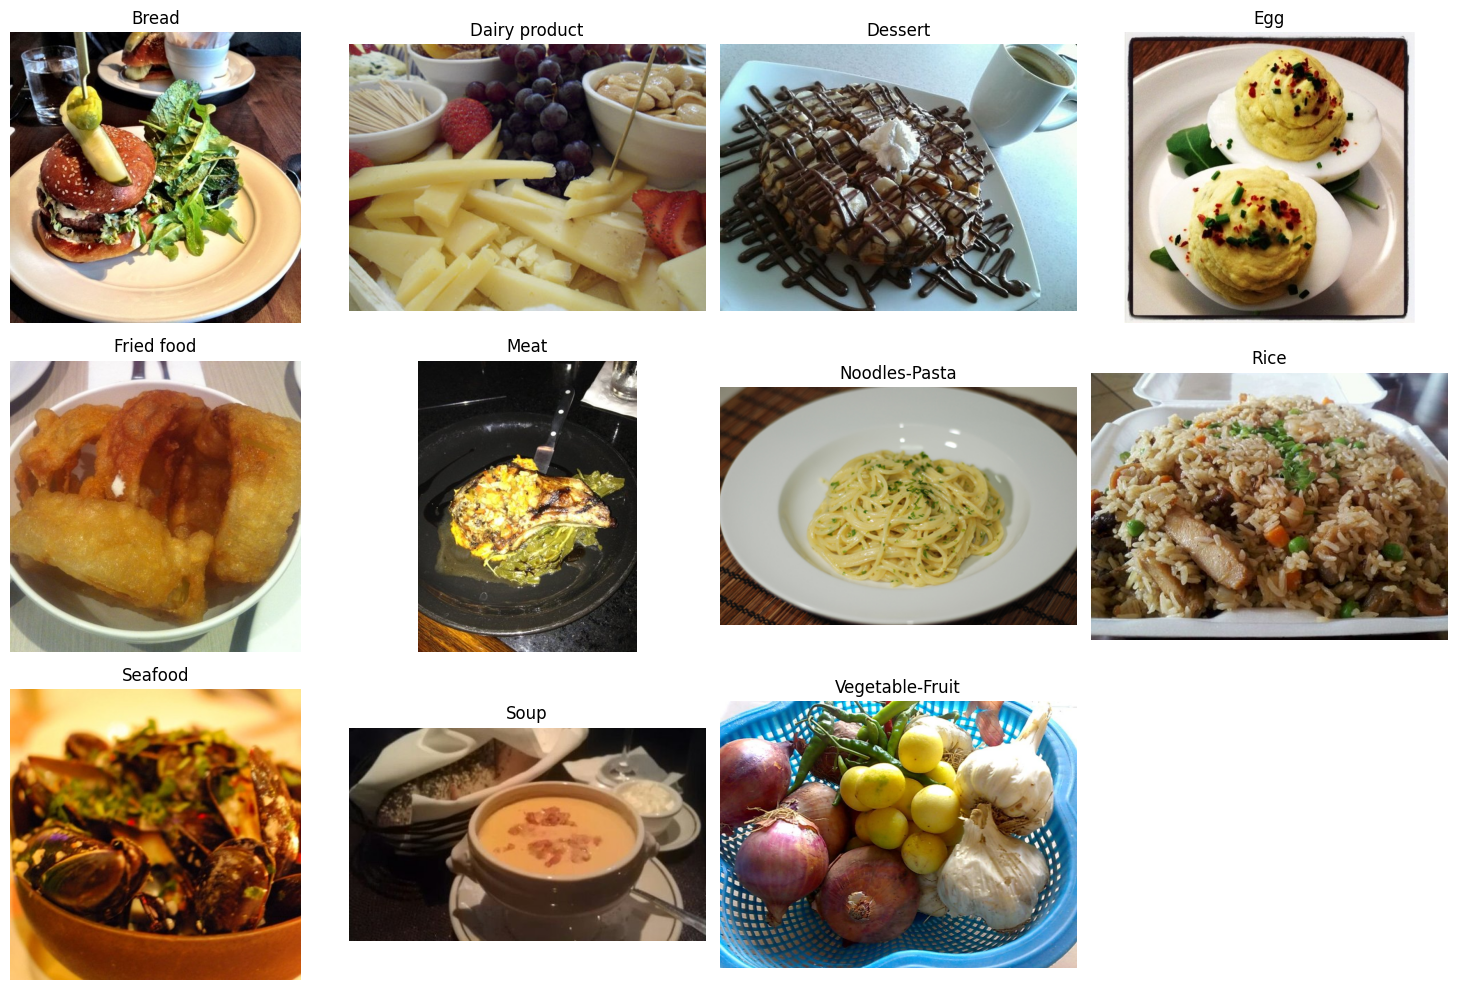

In [4]:
classes = os.listdir(train_path)
print(f"CLasses found : {classes}")


plt.figure(figsize=(15, 10))
for idx, class_name in enumerate(classes):
    class_folder = os.path.join(train_path, class_name)


    images = os.listdir(class_folder)
    random_image = random.choice(images)
    image_path = os.path.join(class_folder, random_image)

    img = Image.open(image_path)

    plt.subplot(3, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = 11

### data transfoming to fit the model

In [6]:
train_transform = transforms.Compose(
    [transforms.Resize(128),
     transforms.CenterCrop(112),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
     ]
)

* validation transform


In [7]:
val_transform =  transforms.Compose(
    [transforms.Resize(128),
     transforms.CenterCrop(112),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
     ]
)

In [8]:
train_dataset = datasets.ImageFolder(root = train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root = validation_path, transform=val_transform)
test_dataset = datasets.ImageFolder(root = eval_path, transform=val_transform)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Training samples: 9866
Validation samples: 3430
Test samples: 9866
Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


## Creating DataLoaders

In [9]:
# Use only subset of data for quick training
from torch.utils.data import Subset
import numpy as np

# Use only 20% of training data
train_indices = np.random.choice(len(train_dataset), size=int(len(train_dataset)*0.2), replace=False)
train_dataset_small = Subset(train_dataset, train_indices)

train_loader = DataLoader(train_dataset_small, batch_size=32, shuffle=True)

In [10]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)

In [11]:
model = models.mobilenet_v3_small(pretrained = True)

C:\Work\Programing Language\Python\Project\Food-11-classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Work\Programing Language\Python\Project\Food-11-classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for params in model.parameters():
    params.requires_grad = False

In [13]:
num_features = model.classifier[0].in_features
model.classifier= nn.Sequential(
    nn.Linear(num_features,128),nn.ReLU(),nn.Dropout(p=0.2),
    nn.Linear(128,11)

)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
epochs = 10


In [15]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [17]:
import time

print(f"\nStarting training: {NUM_EPOCHS} epochs\n")

start_time = time.time()
best_val_acc = 0.0

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    train_loss = train_loss / len(train_loader)


    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)


    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | {epoch_time:.1f}s | "
          f"Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | "
          f"Elapsed: {int(elapsed//60)}m {int(elapsed%60)}s")


total_time = time.time() - start_time

print(f"Best validation accuracy: {best_val_acc:.2f}%")


Starting training: 5 epochs

Epoch 1/5 | 52.2s | Train: 43.5% | Val: 54.8% | Elapsed: 0m 52s
Epoch 2/5 | 42.4s | Train: 56.8% | Val: 59.5% | Elapsed: 1m 34s
Epoch 3/5 | 42.2s | Train: 60.1% | Val: 61.0% | Elapsed: 2m 16s
Epoch 4/5 | 43.6s | Train: 62.0% | Val: 61.5% | Elapsed: 3m 0s
Epoch 5/5 | 52.7s | Train: 63.8% | Val: 61.5% | Elapsed: 3m 53s

Done! Total time: 3m 53s
Best validation accuracy: 61.49%


TRAINING SET Evaluation Results
Loss: 0.9574
Accuracy: 68.07% (6716/9866)
VALIDATION SET Evaluation Results
Loss: 1.1660
Accuracy: 61.49% (2109/3430)
TEST SET Evaluation Results
Loss: 0.9668
Accuracy: 68.07% (6716/9866)
Dataset         Accuracy        Loss      
Training         68.07%         0.9574
Validation       61.49%         1.1660
Test             68.07%         0.9668


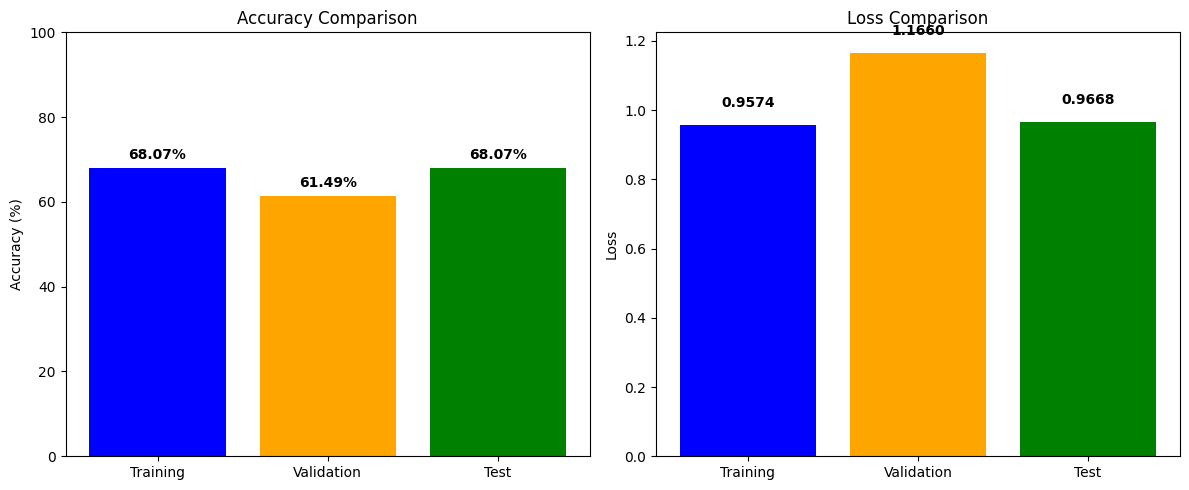

In [20]:
def evaluate_model(model, dataloader, dataset_name):

    model.eval()
    total = 0
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for batch_features, batch_labels in dataloader:



            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)

            # Predictions
            _, predicted = torch.max(outputs.data, 1)

            # Metrics
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            total_loss += loss.item()

    # Calculate metrics
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)

    # Print results

    print(f"{dataset_name} Evaluation Results")

    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")


    return accuracy, avg_loss

# 1. Training Set
train_acc, train_loss = evaluate_model(model, train_loader, "TRAINING SET")

# 2. Validation Set
val_acc, val_loss = evaluate_model(model, val_loader, "VALIDATION SET")

# 3. Test Set
test_acc, test_loss = evaluate_model(model, test_loader, "TEST SET")



print(f"{'Dataset':<15} {'Accuracy':<15} {'Loss':<10}")

print(f"{'Training':<15} {train_acc:>6.2f}%{'':<8} {train_loss:>6.4f}")
print(f"{'Validation':<15} {val_acc:>6.2f}%{'':<8} {val_loss:>6.4f}")
print(f"{'Test':<15} {test_acc:>6.2f}%{'':<8} {test_loss:>6.4f}")

datasets = ['Training', 'Validation', 'Test']
accuracies = [train_acc, val_acc, test_acc]
losses = [train_loss, val_loss, test_loss]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].bar(datasets, accuracies, color=['blue', 'orange', 'green'])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([0, 100])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 2, f"{v:.2f}%", ha='center', fontweight='bold')

# Loss comparison
axes[1].bar(datasets, losses, color=['blue', 'orange', 'green'])
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Comparison')
for i, v in enumerate(losses):
    axes[1].text(i, v + 0.05, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Now to test the model with our own custom images!!


In [21]:
test_transform = transforms.Compose(
    [transforms.Resize(128),
     transforms.CenterCrop(112),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
     ]
)

In [32]:
CLASS_NAMES = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food',
               'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup',
               'Vegetable/Fruit']
def predict_image(image_path):
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Preprocess
    img_tensor = test_transform(img).unsqueeze(0)

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Get results
    predicted_class = CLASS_NAMES[predicted.item()]
    confidence_score = confidence.item() * 100

    # Print results
    # print(f"Image: {image_path}")
    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence_score:.2f}%\n")

    # Show top 3 predictions
    top3_prob, top3_idx = torch.topk(probabilities, 3)
    print("Top 3 predictions:")
    for i in range(3):
        print(f"  {i+1}. {CLASS_NAMES[top3_idx[0][i]]}: {top3_prob[0][i]*100:.2f}%")

    return predicted_class, confidence_score

# ========================
# TEST YOUR IMAGE
# ========================
# Put your image path here
image_path = r'C:\Work\Programing Language\Python\Project\Food-11-classification\custom_test_img\img.png'


predict_image(image_path)



Prediction: Dessert
Confidence: 89.21%

Top 3 predictions:
  1. Dessert: 89.21%
  2. Bread: 6.16%
  3. Meat: 1.29%


('Dessert', 89.21003937721252)